Extract mel-spectrogram from audio

In [1]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, TimeDistributed, LSTM, Input, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss
from tensorflow.keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping


import os
import glob
import matplotlib.pyplot as plt


Find graphic specs

In [2]:
def load_data(dir_path):
    X = []
    y = []
    labels = ['PD', 'HC']
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = img_to_array(load_img(os.path.join(path, img), target_size=(640, 480)))  # Convert image to array
                X.append(preprocess_input(img_arr))  # Preprocess the image using VGG16's preprocess_input method
                y.append(class_num)
            except Exception as e:
                print(e)
    try:
        return np.array(X), np.array(y)
    except Exception as e:
        print(f'Failed to create numpy arrays: {e}')
        return None, None
X, y = load_data('./plots/')
# one-hot encoding
y = to_categorical(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

num_subjects_train = 32  
num_subjects_test = 8  # 20% of 40 subjects
num_observations_per_example = 5 
num_subjects_train = len(X_train) // num_observations_per_example
num_subjects_test = len(X_test) // num_observations_per_example
X_train = X_train.reshape((num_subjects_train, num_observations_per_example, 640, 480, 3))
X_test = X_test.reshape((num_subjects_test, num_observations_per_example, 640, 480, 3))
y_train = y_train.reshape((num_subjects_train, num_observations_per_example, -1))[:, 0, :]
y_test = y_test.reshape((num_subjects_test, num_observations_per_example, -1))[:, 0, :]


train

In [3]:
# Define ResNet model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(640, 480, 3))



In [4]:
model = Sequential()
model.add(TimeDistributed(resnet_model, input_shape=(num_observations_per_example, 640, 480, 3)))
model.add(TimeDistributed(Flatten()))
model.add(SimpleRNN(256))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Use the Adam optimizer with a specified learning rate
optimizer = Adam(learning_rate=0.00001)
model.summary()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=25, batch_size=8)
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print('Loss: %.2f' % loss)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Precision: %.2f%%' % (precision * 100))
print('Recall: %.2f%%' % (recall * 100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 5, 20, 15, 2048)   23587712  
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 614400)         0         
 stributed)                                                      
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               157352192 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 180940418 (690.23 MB)
Trainable params: 18

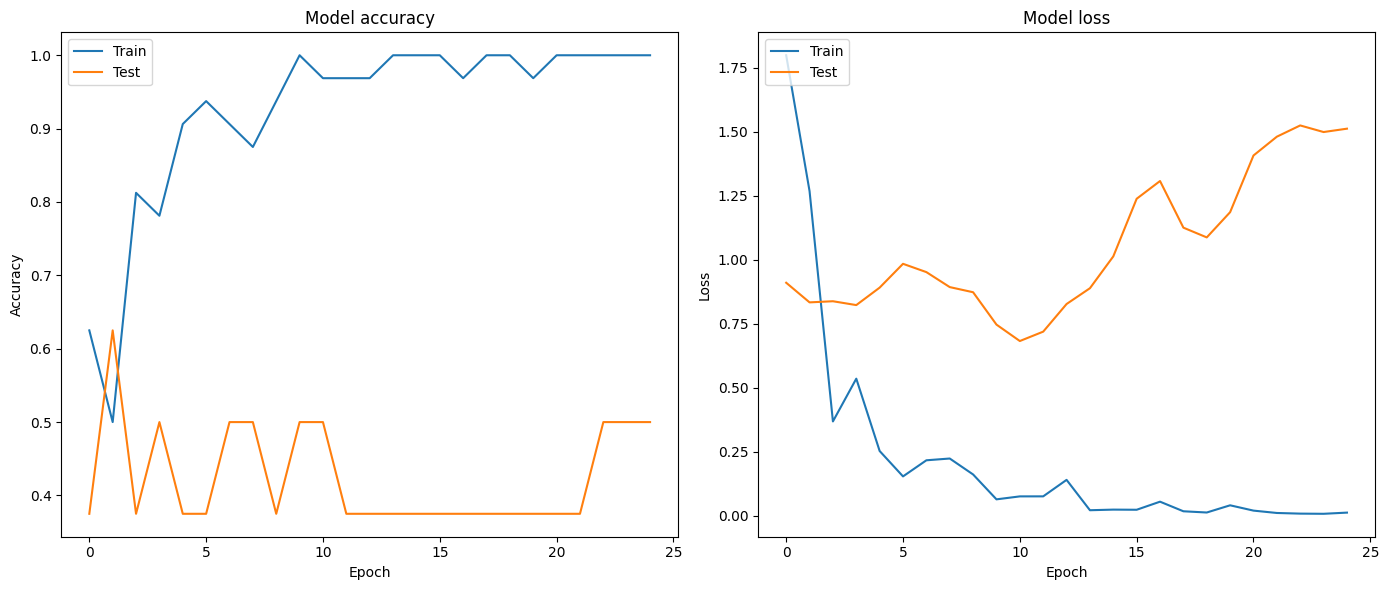

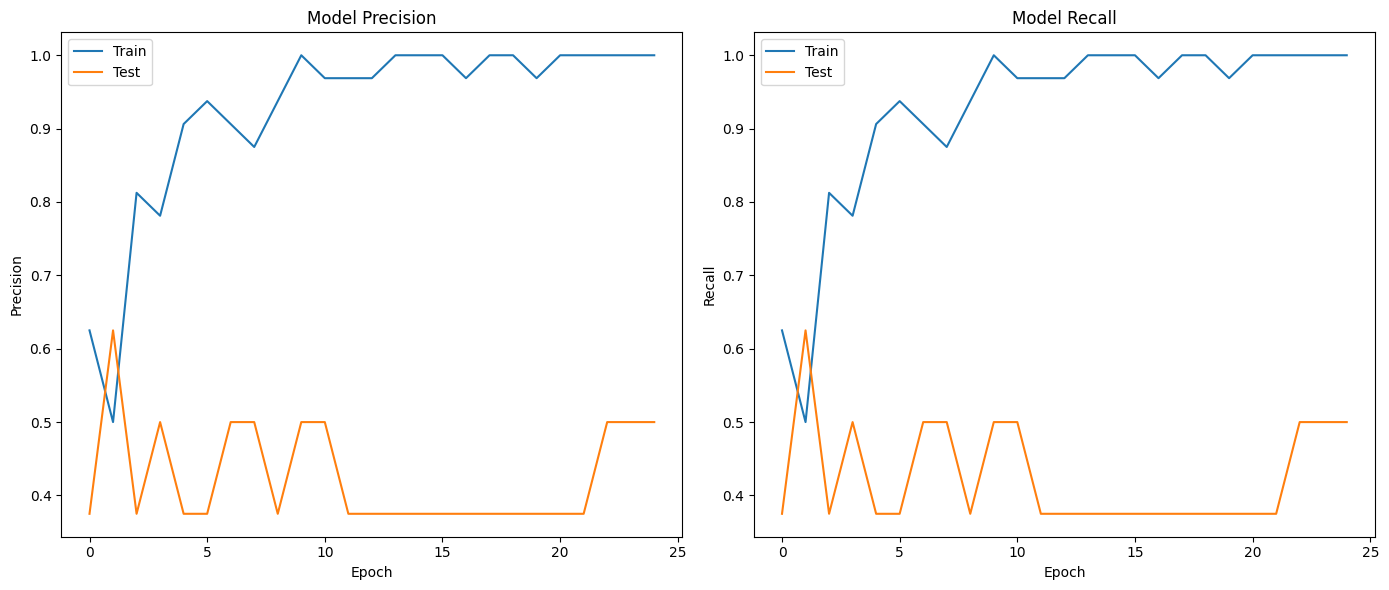

In [5]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Plot training & validation precision values
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation recall values
plt.subplot(1, 2, 2)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [6]:
model.save('my_model.h5') 


C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('my_model.h5')

# Use the loaded model to make predictions or evaluate
y_pred = loaded_model.predict(X_test)

# You may need to process y_pred to match the shape and value range of y_test
# For example, if your y_test is one-hot encoded and y_pred is a softmax output
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

# Now you can calculate accuracy, precision, recall, etc. without re-training the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))


1/1 [==============================] - 5s 5s/step


AxisError: axis 1 is out of bounds for array of dimension 1